In [1]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
PATH = '/kaggle/input/att-database-of-faces/'

In [26]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)

In [27]:
att_dataset = CustomDataset(PATH)

100%|██████████| 40/40 [00:00<00:00, 58.71it/s]


In [28]:
att_dataset[0][0].shape

torch.Size([1, 112, 92])

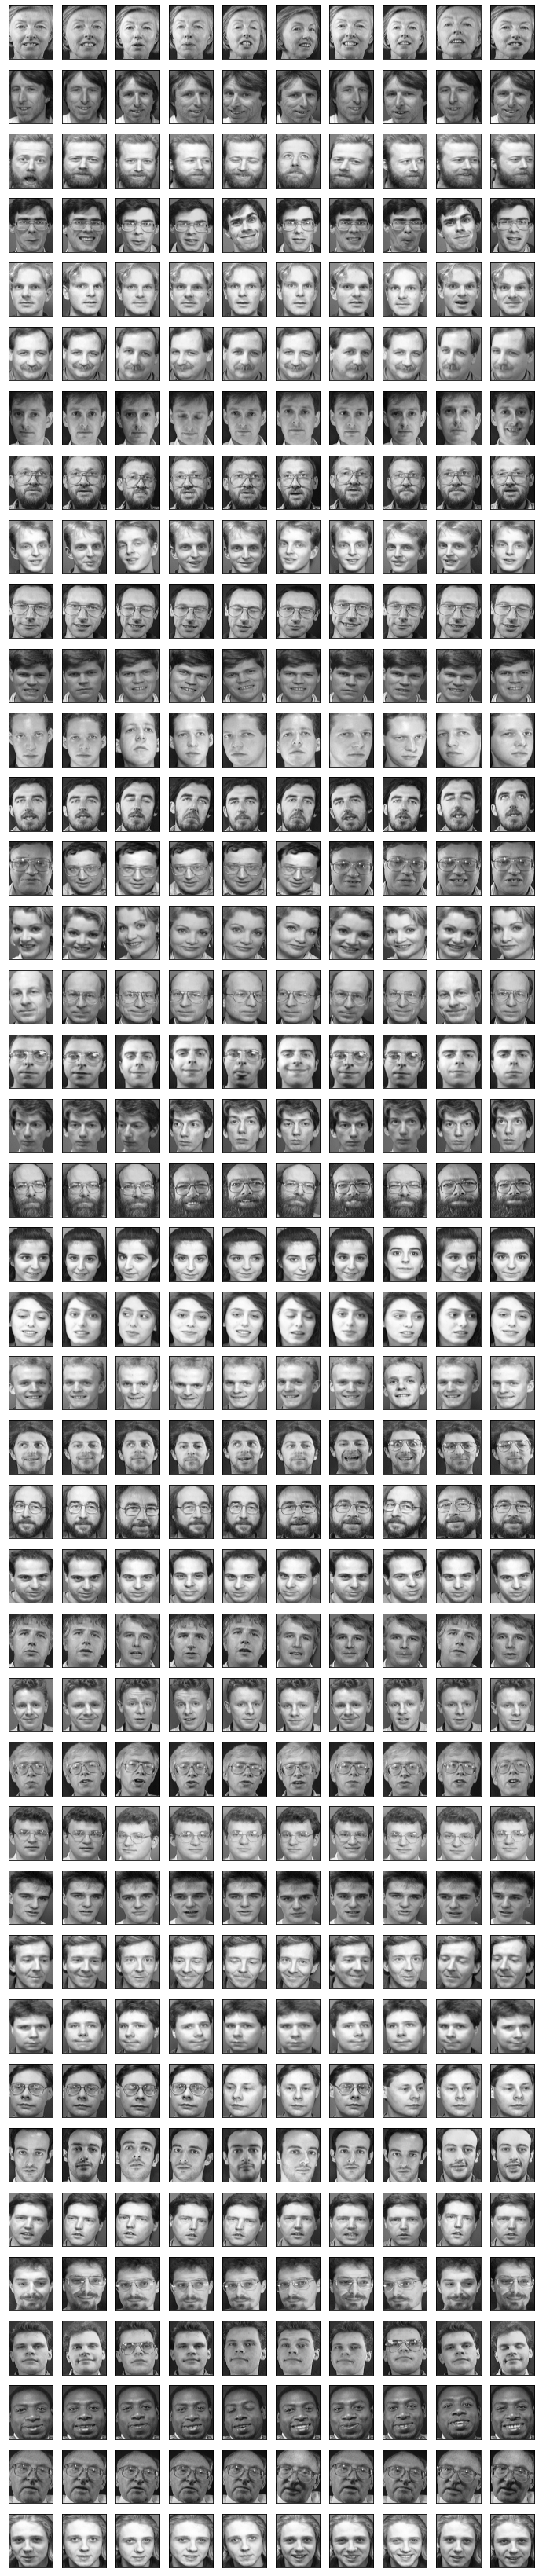

In [29]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [7]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [23]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [30]:
dataset = list(att_dataset)

In [36]:
train = dataset[0:5]

In [107]:
type(train)

list

In [38]:
triplets = get_random_triplets(train)

In [39]:
triplets.shape

torch.Size([200, 3, 1, 112, 92])

In [97]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,3))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        
        self.conv     = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=3072, out_features=1024)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=1024, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))
        

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.conv(x)
        x = x.view(-1, 6*4*128)
        # x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [103]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(1, 16, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(5, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): Re

In [105]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [110]:
cost = []

epochs = 50
for epoch in range(epochs):

    triplets = get_random_triplets(train)

#     apn = model(triplets.cuda())
    apn = model(triplets)

    optimizer.zero_grad()
    loss = triplet_loss(*apn)
    # loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')

Epoch:[1/50] , Cost : 0.0012687812559306622
Epoch:[2/50] , Cost : 0.000281610555248335
Epoch:[3/50] , Cost : 0.0
Epoch:[4/50] , Cost : 0.00017751850828062743
Epoch:[5/50] , Cost : 0.0002482370182406157
Epoch:[6/50] , Cost : 0.0004931602743454278
Epoch:[7/50] , Cost : 0.0
Epoch:[8/50] , Cost : 0.0


KeyboardInterrupt: 

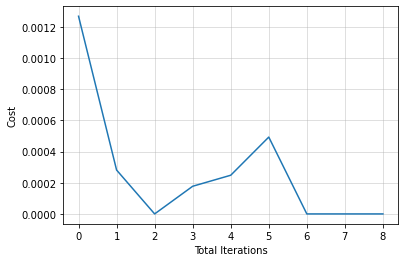

In [111]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(cost)), cost)
plt.grid(alpha=0.5)
plt.show()

In [114]:
apn[0].mean()

tensor(0.1835, grad_fn=<MeanBackward0>)

In [115]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([1.6064, 1.6064, 1.6064, 1.6064, 1.6866, 1.6866, 1.6866, 1.6866, 2.9275,
        2.9275, 2.9275, 2.9275, 1.6197, 1.6197, 1.6197, 1.6197, 1.7783, 1.7783,
        1.7783, 1.7783, 2.5095, 2.5095, 2.5095, 2.5095, 0.6116, 0.6116, 0.6116,
        0.6116, 0.0104, 0.0104, 0.0104, 0.0104, 2.9902, 2.9902, 2.9902, 2.9902,
        1.3867, 1.3867, 1.3867, 1.3867, 0.8123, 0.8123, 0.8123, 0.8123, 0.4292,
        0.4292, 0.4292, 0.4292, 1.2318, 1.2318, 1.2318, 1.2318, 0.9057, 0.9057,
        0.9057, 0.9057, 0.9744, 0.9744, 0.9744, 0.9744, 1.2522, 1.2522, 1.2522,
        1.2522, 0.7130, 0.7130, 0.7130, 0.7130, 1.0787, 1.0787, 1.0787, 1.0787,
        0.8052, 0.8052, 0.8052, 0.8052, 1.2058, 1.2058, 1.2058, 1.2058, 0.5886,
        0.5886, 0.5886, 0.5886, 1.0903, 1.0903, 1.0903, 1.0903, 1.0416, 1.0416,
        1.0416, 1.0416, 0.8112, 0.8112, 0.8112, 0.8112, 0.5132, 0.5132, 0.5132,
        0.5132, 1.3143, 1.3143, 1.3143, 1.3143, 0.0064, 0.0064, 0.0064, 0.0064,
        0.6751, 0.6751, 0.6751, 0.6751, 

In [116]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([ 8.2594,  2.9890, 11.1509,  6.9118, 12.6492,  5.0427, 10.1525,  8.0673,
        11.0241,  4.2985,  7.9445,  7.6991,  9.3138,  5.6458,  5.9179,  6.0416,
        12.3429,  6.7529,  6.9444,  7.4582,  7.5808,  5.0139,  5.3514,  5.1202,
        12.1579,  6.6565,  8.8993,  7.7298,  9.8750,  5.8849,  7.3639,  6.0027,
        11.0205,  8.2113,  9.1796, 10.0514, 12.7175,  7.3834,  7.8095,  8.2499,
        13.1582,  5.4360, 17.3678,  4.0496,  8.8808,  3.1232, 12.1587,  4.5453,
         9.4676,  3.5180,  8.4454,  2.3686, 12.7280,  3.6211, 10.4874,  2.1957,
        12.2732,  4.8630, 11.1277,  2.7273,  8.9018,  3.2002, 10.9451,  3.2440,
        12.6385,  2.7392, 13.2067,  3.6457,  9.2719,  3.8347,  9.8547,  2.6225,
        10.4324,  4.1208, 11.6871,  3.5207,  9.8447,  3.7744,  8.9804,  2.4797,
         6.7385,  4.4058,  9.2496,  2.8528,  5.6680,  3.2496,  9.8187,  3.6594,
         4.2136,  3.8281,  8.5995,  3.4306,  6.5561,  3.5888, 14.3388,  4.2398,
         6.6976,  3.4570,  9.3181,  2.94

In [ ]:
p.max() , p.mean() , n.max(), n.mean()